In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import time
import os.path
from varname import nameof
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# load the patient data
_data = np.load('data/patients.npy', allow_pickle=True).tolist()
patients = _data['patients']
print("Loaded!")

Loaded!


In [ ]:
# load the SQL queries
_data = np.load('data/SQL_queries.npy', allow_pickle=True).tolist()
SQL_queries = _data['SQL_queries']
print("Loaded!")

In [5]:
# Function to query the database for a specific feature
def get_feature(feature_name):
    
    '''
    Queries the MIMIC-III database for the specified feature.
    Requires a dictionary named SQL_queries with feature names as keys, and the corresponding SQL queries as values.
    '''
    
    start = time.time()

    # Query the database
    query = SQL_queries[feature_name]

    # Execute the query and fetch the result
    cur.execute(query)
    conn.commit()
    data = cur.fetchall()

    # Store the result of the query as a pandas dataframe
    result = pd.DataFrame(data, columns=["subject_id", "hadm_id", "itemid", "charttime", "valuenum", "valueuom"])

    end = time.time()
    
    # Print run time
    print("The '{}' query took {} seconds".format(feature_name, round((end-start),2)))
    
    # Return the feature
    return result

In [6]:
# Function that removes missing values
def remove_nan(feature):
    
    '''
    feature is a pandas DataFrame representing some feature queried from the MIMIC-III database
    '''
    
    # Remove rows where valuenum is not a number
    result = feature.dropna(axis=0, subset=['valuenum'])
    
    # Calculate how many rows were removed
    before, after = len(feature), len(result)
    diff = before - after
    
    # Print how many rows were removed
    print("{} rows were removed ({:.2f}% of all measurements)".format(diff, 100*diff/before))
    
    # Return the cleaned feature dataframe
    return result

In [7]:
# Function that creates a list of numpy arrays with all measurements for each patient sorted by time
def collect_all_measurements(feature, patients):
    '''
    feature is a pandas DataFrame representing some feature queried from the MIMIC-III database
    patients is a pandas DataFrame that has been previously loaded, containing patient details for patients of interest
    '''
    
    start = time.time()
    
    # Create an empty list in which to store the data
    results = []
    
    # Extract subject ID, hospital admission time and hospital discharge time
    m = len(patients) # number of patients
    subject_id = patients['subject_id']
    admittime = patients['admittime']
    dischtime = patients['dischtime']
    
    # Iterate over every patient
    for i in range(m):
    
        # Define subject ID
        subj_id = int(subject_id[i])
    
        # Select data for this subject
        measurements = feature[feature['subject_id']==subj_id]
        
        # Get hospital admission and discharge times for this subject
        admit = admittime[i]
        disch = dischtime[i]
        
        # Discard measurements before admission and after discharge
        measurements = measurements[measurements['charttime'] > admit] # remove measurements before admission
        measurements = measurements[measurements['charttime'] < disch] # remove measurements after discharge
        
        # Sort the measurements by time
        measurements = measurements.sort_values(by=['charttime'])
        
        # Create a final array for this subject, with one column for datetimes and one column for measurements
        res = np.vstack((np.array([x.to_pydatetime() for x in measurements['charttime']]), np.array(measurements['valuenum']))).T
        
        # Append this subjects' array to the results list (after casting to a numpy array)
        results.append(res)
        
    end = time.time()
    
    # Print run time
    print("It took {} minutes to collect all the measurements for each patient".format(round((end-start)/60,2)))
        
    # Return the results
    return results

In [21]:
# Iterate over every feature
for i in SQL_queries:
    
    # Define a pre-cursor variable name
    precursor = '_' + i
    
    # Query the database for the feature
    exec(precursor + " = get_feature('{}')".format(i))
    
    # Remove any missing values
    exec(precursor + " = remove_nan({})".format(precursor))
    
    # Collect measurements for every patient, excluding measurements outside the relevant hospital stay
    exec(i + " = collect_all_measurements({}, patients)".format(precursor))
    
    # Print a separator between features
    print('')

The 'bicarb' query took 5.19 seconds
209 rows were removed (0.03% of all measurements)
It took 2.14 minutes to collect all the measurements for each patient

The 'bilirubin' query took 2.56 seconds
29 rows were removed (0.01% of all measurements)
It took 2.08 minutes to collect all the measurements for each patient

The 'bp' query took 28.61 seconds
15168 rows were removed (0.25% of all measurements)
It took 8.61 minutes to collect all the measurements for each patient

The 'fio2' query took 2.39 seconds
144 rows were removed (0.11% of all measurements)
It took 1.68 minutes to collect all the measurements for each patient

The 'gcs_eyes' query took 9.25 seconds
529 rows were removed (0.03% of all measurements)
It took 2.94 minutes to collect all the measurements for each patient

The 'gcs_motor' query took 8.82 seconds
825 rows were removed (0.05% of all measurements)
It took 2.83 minutes to collect all the measurements for each patient

The 'gcs_verbal' query took 9.03 seconds
1249 ro

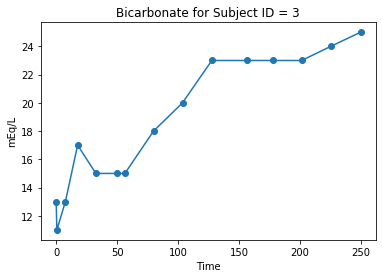

In [23]:
# Select data for one patient
patient = 0
data = bicarb[patient]

# Re-format time to hours since hospital admission
diff_time = data[:,0]-data[0,0]
days = np.array([x.days for x in diff_time])
seconds = np.array([x.seconds for x in diff_time])
corrected_time = days*24 + seconds/(60*60)

# Plot the data
plt.plot(corrected_time, data[:,1], '-o')
plt.xlabel('Time')
plt.ylabel(_bicarb['valueuom'].iloc[0])
plt.title('Bicarbonate for Subject ID = {}'.format(patients['subject_id'].iloc[patient]));

In [25]:
# Save to raw_features.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {
    '_bicarb': _bicarb, 'bicarb': bicarb,
    '_bilirubin': _bilirubin, 'bilirubin': bilirubin,
    '_bp': _bp, 'bp': bp,
    '_fio2': _fio2, 'fio2': fio2,
    '_gcs_eyes': _gcs_eyes, 'gcs_eyes': gcs_eyes,
    '_gcs_motor': _gcs_motor, 'gcs_motor': gcs_motor,
    '_gcs_verbal': _gcs_verbal, 'gcs_verbal': gcs_verbal,
    '_hr': _hr, 'hr': hr,
    '_pao2': _pao2, 'pao2': pao2,
    '_potassium': _potassium, 'potassium': potassium,
    '_sodium': _sodium, 'sodium': sodium,
    '_temp': _temp, 'temp': temp,
    '_urea': _urea, 'urea': urea,
    '_urine': _urine, 'urine': urine,
    '_wbc': _wbc, 'wbc': wbc
}
np.save('data/raw_features.npy',tosave)
print("Saved!")

Saved!
